# Map 3D data

We will map using noisy data, where the "truth" function is 
$$
f(x) = sin(kx+ly - \omega t)
$$

We purposefully added a time dimension, since we are trying to map Argo data along the time axis too. 

In [1]:
import gpytorch
import torch
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
np.random.seed(1234);
xr.set_options(display_style='html');

In [3]:
def fake_3d_data(n_samples, rangex=1, rangey=1, ranget=1, 
                 k=2*np.pi, l=2*np.pi, om=2*np.pi, eta=0.1):
    
    # generate a vector that has n_samples rows and 3 rows corresponding to x,y,t
    xND = np.random.rand(n_samples, 3)
    
    # Since the above vector was generated using uniform distributions that vary between 0,1
    # we now rescale them to dimensionalize them (ex. if we want x to vary between 0-10, we set rangex=10)
    x = xND
    x[:,0] = rangex*x[:,0]
    x[:,1] = rangey*x[:,1]
    x[:,2] = ranget*x[:,2]
        
    # convert to xarray since we will be getting the argo data in this form
    x = xr.DataArray(x,  dims=["samplenum", "coordinate"], coords=[range(n_samples), ['x','y','t']])
    
    # generate some random uncorrelated noise with a gaussian distribution
    # This will be added to each sample, and corresponds to the observational noise 
    yerr = eta * np.random.randn(n_samples)
    
    y = np.sin(k*x.sel(coordinate='x') + l*x.sel(coordinate='y') - om*x.sel(coordinate='t')) + yerr
    
    return x, y

In [4]:
# Generate a fake data set at some random sample points.
eta = 0.1
rangex=3 
rangey=3 
ranget=2


[x,y] = fake_3d_data(1200, rangex, rangey, ranget,
                     1, 1.5 , 2*np.pi, eta)

In [5]:
x.shape

(1200, 3)

Text(0, 0.5, 'y')

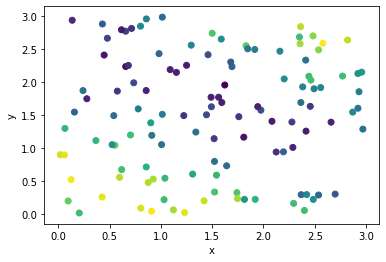

In [6]:
# Pick a little bit of data around some time to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel)
plt.xlabel('x')
plt.ylabel('y')
# notice that the data looks sinusoidal

Text(0, 0.5, 't')

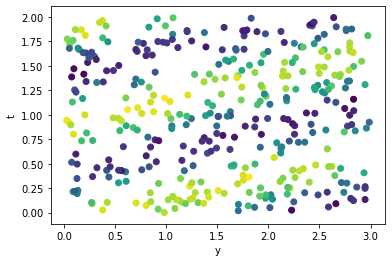

In [7]:
# Pick a little bit of data around some x,y to plot 
# The interpolation effort will be done by GP later, so no point interpolating now.
y_sel = y.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='x')<1.5 , x.sel(coordinate='x')>0.5), drop='true')

plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), c=y_sel)
plt.xlabel('y')
plt.ylabel('t')
# notice that the data is a wave that propogates towards larger y as time progresses

In [8]:
# convert to torch tensors, since that is what PyTorch and GPyTorch work with.
train_x = torch.from_numpy(x.values).float()
train_y = torch.from_numpy(y.values).float()

In [9]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP): # setup the class which inherits the ExactGP model
    # initialize the class with X_input, Y_input and a likelihood
    def __init__(self, train_x, train_y, likelihood):
        
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # This calls the __init__ of the inherited class (gpytorch.models.ExactGP),
        # and passes the training data and a likelihood to it.
        # Also ExactGPModel objects have access to 'ExactGP' functions, since it has inherited it.
        
        # Chose a constant mean.
        self.mean_module = gpytorch.means.ConstantMean()
        # ScaleKernel gives the covariance function a scaling factor (K_scale = theta*K_orig)
        self.covar_module = gpytorch.kernels.ScaleKernel(
                            gpytorch.kernels.RBFKernel(ard_num_dims=3, 
                                                       has_lengthscale=True))#train_x.shape[1])) 
                                        #,lengthscale_prior=[0.5, 0.5, 0.5]))

        # forward takes some x input of size nXd (n-num samples, d-input dim),
        # and returns the multivariate gaussian with mu(x) and cov(x)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [11]:
hypers = {
    'likelihood.noise_covar.noise': torch.tensor(.01),
    'covar_module.base_kernel.lengthscale': torch.tensor([0.5, 0.5, 0.5]),
    'covar_module.outputscale': torch.tensor(1.),
}
model.initialize(**hypers);
# initialized all length/time scales with same values

In [13]:
print(model.covar_module.outputscale.item())
print(model.covar_module.base_kernel.lengthscale)

1.0
tensor([[0.5000, 0.5000, 0.5000]], grad_fn=<SoftplusBackward>)


In [15]:
# Find optimal model hyperparameters
model.train() 
likelihood.train();
# these calls set the model and likelihood into training modes 
# (they don't actually train anything)
# Use the adam optimizer
optimizer = torch.optim.Adam([
                {'params': model.parameters()},  # Includes GaussianLikelihood parameters
                              ], lr=0.1) # set learning rate of 0.1

In [16]:

# "Loss" for GPs - the marginal log likelihood log(p(y(x)))
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


training_iter = 100 # set as many stels as we want to take 

loss_vals = np.zeros(training_iter)
for i in range(training_iter):
    
        # Zero gradients from previous iteration
    optimizer.zero_grad()

    # Output from model
    output = model(train_x)

    # Calc loss and backprop gradients
    # loss is defined is -log(p(Y(x)))

    # the way the PyTorch optimizer works is that it looks for a variable called loss,
    # which also has a gradient (calc by calling backward), and tries to reduce it.
    loss = -mll(output, train_y)

    loss.backward()
    
    if np.mod(i,10)==0:
        print('Iter %d/%d - Loss: %.3f   lengthscale1: %.3f lengthscale2: %.3f lengthscale3: %.3f  noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale[0][0].item(),
            model.covar_module.base_kernel.lengthscale[0][1].item(),
            model.covar_module.base_kernel.lengthscale[0][2].item(),
            model.likelihood.noise.item()
              ))
    loss_vals[i] = loss.item()
        
    optimizer.step()

Iter 1/100 - Loss: 0.092   lengthscale1: 0.500 lengthscale2: 0.500 lengthscale3: 0.500  noise: 0.010
Iter 11/100 - Loss: -0.393   lengthscale1: 0.893 lengthscale2: 0.877 lengthscale3: 0.288  noise: 0.008
Iter 21/100 - Loss: -0.428   lengthscale1: 1.218 lengthscale2: 1.093 lengthscale3: 0.240  noise: 0.009
Iter 31/100 - Loss: -0.408   lengthscale1: 1.383 lengthscale2: 1.085 lengthscale3: 0.227  noise: 0.008
Iter 41/100 - Loss: -0.427   lengthscale1: 1.403 lengthscale2: 1.027 lengthscale3: 0.224  noise: 0.009
Iter 51/100 - Loss: -0.415   lengthscale1: 1.340 lengthscale2: 1.031 lengthscale3: 0.228  noise: 0.008
Iter 61/100 - Loss: -0.433   lengthscale1: 1.330 lengthscale2: 1.050 lengthscale3: 0.234  noise: 0.009
Iter 71/100 - Loss: -0.435   lengthscale1: 1.300 lengthscale2: 0.973 lengthscale3: 0.241  noise: 0.008
Iter 81/100 - Loss: -0.426   lengthscale1: 1.259 lengthscale2: 0.920 lengthscale3: 0.250  noise: 0.008
Iter 91/100 - Loss: -0.446   lengthscale1: 1.255 lengthscale2: 0.879 length

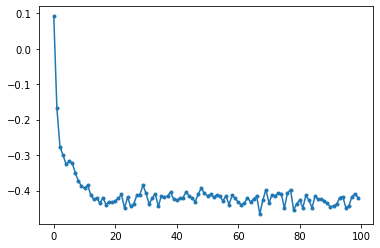

In [17]:
plt.plot(loss_vals, marker='.')

In [18]:
print('Noise std: ', model.likelihood.noise_covar.noise.item()**0.5)
print('Scale kernel: ',model.covar_module.outputscale.item())
print('Length/time scales: ',model.covar_module.base_kernel.lengthscale)

Noise std:  0.09104522931706714
Scale kernel:  1.3790371417999268
Length/time scales:  tensor([[1.1920, 0.8363, 0.2660]], grad_fn=<SoftplusBackward>)


In [19]:
# note that tjis is a huge number of test points, compared
# to what we were doing with george.
test_pts = torch.from_numpy(
            np.array(np.meshgrid(np.linspace(0,rangex,50), 
                       np.linspace(0,rangey,50),
                       np.linspace(0,ranget,20))).reshape(3,-1).T).float()

In [20]:
test_pts_xr = xr.DataArray(test_pts.numpy(),  dims=["test_pt_num","coordinate"], 
                        coords=[range(test_pts.shape[0]), ['x','y','t']] ) 

In [21]:
# Get into evaluation (predictive posterior) mode
# this is the specific way that PyTorch works, basically sort
# of like freezing parameters, stop tracking gradients.
model.eval()
likelihood.eval();

In [22]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    #test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_pts))

In [23]:
mean_obs = observed_pred.mean
var_obs  = observed_pred.variance
samp1    = observed_pred.sample()
# still takes time. but still much faster. :) 

In [24]:
pred_mean = xr.DataArray(mean_obs.numpy(),  dims={"test_pt_num"})
pred_var = xr.DataArray(var_obs.detach().numpy(),  dims={"test_pt_num"})
pred_samp = xr.DataArray(samp1.numpy(),  dims={"test_pt_num"})

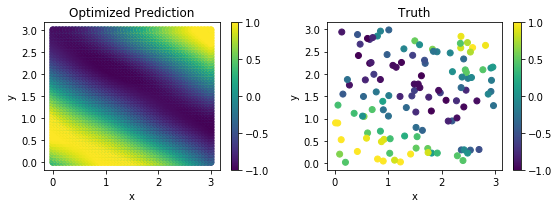

In [26]:
plt.figure(figsize=(8,3))
plt.subplot(121)
y_sel = pred_mean.where(np.logical_and(test_pts_xr.sel(coordinate='t')<1 ,
                                   test_pts_xr.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts_xr.where(np.logical_and(test_pts_xr.sel(coordinate='t')<1 , 
                                   test_pts_xr.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), 
            c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Optimized Prediction')

plt.subplot(122)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

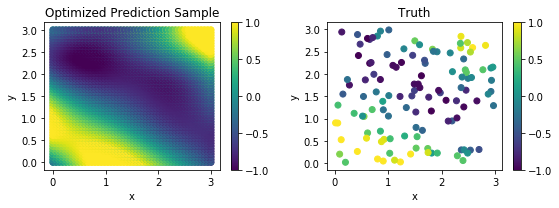

In [28]:
plt.figure(figsize=(8,3))
plt.subplot(121)
y_sel = pred_samp.where(np.logical_and(test_pts_xr.sel(coordinate='t')<1 ,
                                   test_pts_xr.sel(coordinate='t')>0.8), drop='true')
x_sel = test_pts_xr.where(np.logical_and(test_pts_xr.sel(coordinate='t')<1 , 
                                   test_pts_xr.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), 
            c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Optimized Prediction Sample')

plt.subplot(122)
y_sel = y.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='t')<1 , x.sel(coordinate='t')>0.8), drop='true')

plt.scatter(x_sel.sel(coordinate='x'), x_sel.sel(coordinate='y'), c=y_sel, vmin=-1, vmax=1)
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

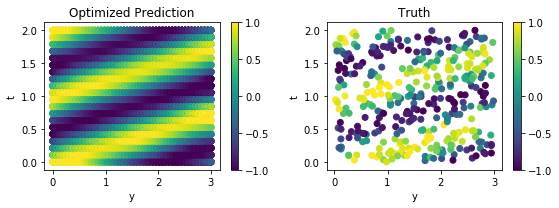

In [27]:
plt.figure(figsize=(8,3))
plt.subplot(121)
y_sel = pred_mean.where(np.logical_and(test_pts_xr.sel(coordinate='x')<1.5 ,
                                   test_pts_xr.sel(coordinate='x')>0.5), drop='true')
x_sel = test_pts_xr.where(np.logical_and(test_pts_xr.sel(coordinate='x')<1.5 , 
                                   test_pts_xr.sel(coordinate='x')>0.5), drop='true')

plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), 
            c=y_sel, vmin=-1, vmax=1)
plt.xlabel('y')
plt.ylabel('t')
plt.colorbar()
plt.title('Optimized Prediction')

plt.subplot(122)
y_sel = y.where(np.logical_and(x.sel(coordinate='x')<1.5 , 
                               x.sel(coordinate='x')>0.5), drop='true')
x_sel = x.where(np.logical_and(x.sel(coordinate='x')<1.5 , 
                               x.sel(coordinate='x')>0.5), drop='true')

plt.scatter(x_sel.sel(coordinate='y'), x_sel.sel(coordinate='t'), 
            c=y_sel, vmin=-1, vmax=1)
plt.xlabel('y')
plt.ylabel('t')
plt.colorbar()
plt.title('Truth')

plt.tight_layout()

In [ ]:
# Here we got pretty far from using the exponential kernel. This is because 
# the origional function is very smooth - the power spectrum is only delta function at k,l, omega. 
# However, most natural data will not be like this - it generally has some sort of piecewise powerspectrum. If anything,
# this kernal might have made the function rougher than what we entered in. 